In [2]:
#imports....
import numpy as np
import matplotlib.pyplot as plt

Build a Gibbs sampler for the 8 × 8 Ising model at
temperatures Temp ∈ {1, 1.5, 2}. Compute the empirical expectations of
ETemp(X(1,1)X(2,2)) and ETemp(X(1,1)X(8,8)) (45)
using two different methods; see below. Compare the estimates to the nearlyexact values computed in § 1; see Table 1.
Programming Note: A convenient way to handle boundaries is to embed the
n×n lattice in the interior of an (n+ 2)×(n+ 2) lattice whose boundary values
are set to zero, and then visit only the n × n interior sites of the larger lattice.

In [3]:
# Computer Exercise 9

def rand_init(size = 8, p = 0.5):
    #embed the n x n lattice in a (n+2) x (n+2) lattice with 0s on the boundary
    lattice = np.random.randint(low =0, high = 2, size = (size+2, size+2)) * 2 - 1
    lattice[0,:] = 0
    lattice[:,0] = 0
    lattice[size+1,:] = 0
    lattice[:,size+1] = 0
    return lattice

# init Gibbs sampler at random configuration
def sweep(lattice, temp,size = 8):
    for i in range(1,size+1):
        for j in range(1,size+1):
            lattice[i,j] = pixel_sample(lattice,i,j,temp)
    return lattice

# Expression (40): from Ising prior, sampling from this cond. dist. p(Xs|sX) is affected by the states of the neighbors
def prior(lattice,curr,i,j,temp):
    return np.exp(curr*(1/temp)*(lattice[i-1,j]+lattice[i+1,j]+lattice[i,j-1]+lattice[i,j+1]))

def pixel_sample(lattice,i,j,temp):
    p = prior(lattice,lattice[i,j],i,j,temp)/(prior(lattice,1,i,j,temp)+prior(lattice,-1,i,j,temp))
    # draw xs according to p
    if lattice[i,j] > 0:
        return np.random.choice([1,-1],p=[p,1-p])
    else:
        return np.random.choice([-1,1],p=[p,1-p])
    
# Gibbs sampler
def lattice_sampler(temp,size = 8, num_sweeps = 25):
    lattice = rand_init(size)
    for k in range(num_sweeps):
        sweep(lattice,temp,size)
    return lattice

In [41]:
#method 1
#need to run with 1000

def method1(size = 8, num_samples = 1000):
    from tqdm import tqdm
    
    expectation_dict  = {}
    temps = [1,1.5,2]
    for temp in temps:
        data = []
        for i in tqdm(range(num_samples)):
            lattice = lattice_sampler(temp,size)
            data.append(lattice)
        
        # calculate the expectation - Expression (47)
        E12 = np.sum([data[i][1,1]* data[i][2,2] for i in range(num_samples)]) / num_samples
        E18 = np.sum([data[i][1,1]* data[i][8,8] for i in range(num_samples)]) / num_samples
        print("Temp = ", temp)
        print("E12 = ", E12)
        print("E18 = ", E18)
        expectation_dict[temp] = [E12,E18]
    return expectation_dict

method1()

100%|██████████| 1000/1000 [01:14<00:00, 13.37it/s]


Temp =  1
E12 =  0.934
E18 =  0.52


100%|██████████| 1000/1000 [01:17<00:00, 12.94it/s]


Temp =  1.5
E12 =  0.724
E18 =  0.314


100%|██████████| 1000/1000 [01:20<00:00, 12.46it/s]

Temp =  2
E12 =  0.546
E18 =  0.158


{1: [0.934, 0.52], 1.5: [0.724, 0.314], 2: [0.546, 0.158]}

In [39]:
def method2(size = 8, num_sweeps = 25000):
    from tqdm import tqdm

    temps = [1,1.5,2]
    expectation_dict  = {}
    for temp in temps:
        # initialize the lattice
        lattice = rand_init(size)
        E12 = 0
        E18 = 0
        counter = 0
        for k in tqdm(range(num_sweeps)):
            lattice = sweep(lattice,temp,size)
            # following burn-in period, we start collecting data
            if k > 100:
                counter += 1
                E12 += lattice[1,1]* lattice[2,2]
                E18 += lattice[1,1]* lattice[8,8]
        # final estimate of the expectation - Expression (47)
        expectation_dict[temp] = [E12/counter,E18/counter]

    return expectation_dict


method2()
    

100%|██████████| 25000/25000 [01:22<00:00, 303.62it/s]


{1: [0.9514036708301539, 0.9028073416603076],
 1.5: [0.7584641953492108, 0.5443190489577895],
 2: [0.49773083256355677, 0.10807662958351741]}

In [5]:
#Exercise 10

def noise_sample(size = 100):
    #embed the n x n lattice in a (n+2) x (n+2) lattice with 0s on the boundary
    #sample the noise from a uniform distribution N(0,4)
    lattice = 2*np.random.standard_normal(size = (size+2, size+2))
    lattice[0,:] = 0
    lattice[:,0] = 0
    lattice[size+1,:] = 0
    lattice[:,size+1] = 0
    return lattice

def posterior(lattice,i,j,y,xs,temp,sig):
    return np.exp(xs*(1/temp)*(lattice[i-1,j]+lattice[i+1,j]+lattice[i,j-1]+lattice[i,j+1]) - (1/(2*sig**2))*(y-xs)**2)
    
def corrupted_pixel_sample(lattice,i,j,temp,corrupted_lattice):
    sig = 2
    y = corrupted_lattice[i,j]
    p = posterior(lattice,i,j,y,lattice[i,j],temp,sig)/(posterior(lattice,i,j,y,1,temp,sig)+posterior(lattice,i,j,y,-1,temp,sig))
    # draw xs according to p
    if lattice[i,j] > 0:
        return np.random.choice([1,-1],p=[p,1-p])
    else:
        return np.random.choice([-1,1],p=[p,1-p])
    

def ICM_pixel_sample(lattice,i,j,temp,corrupted_lattice):
    sig = 2
    y = corrupted_lattice[i,j]
    p = posterior(lattice,i,j,y,lattice[i,j],temp,sig)/(posterior(lattice,i,j,y,1,temp,sig)+posterior(lattice,i,j,y,-1,temp,sig))
    # draw xs according to p
    if lattice[i,j] > 0:
        return 1 if p > 0.5 else -1
    else:
        return -1 if p > 0.5 else 1
    

def ICM_lattice_sampler(corrupted_lattice,temp,size = 100, num_sweeps = 50):
    lattice = rand_init(size)
    for k in range(num_sweeps):
        for i in range(1,size+1):
            for j in range(1,size+1):
                lattice[i,j] = ICM_pixel_sample(lattice,i,j,temp,corrupted_lattice)
    return lattice
    

def corrupted_lattice_sampler(corrupted_lattice,temp,size = 100, num_sweeps = 50):
    lattice = rand_init(size)
    for k in range(num_sweeps):
        for i in range(1,size+1):
            for j in range(1,size+1):
                lattice[i,j] = corrupted_pixel_sample(lattice,i,j,temp,corrupted_lattice)
    return lattice


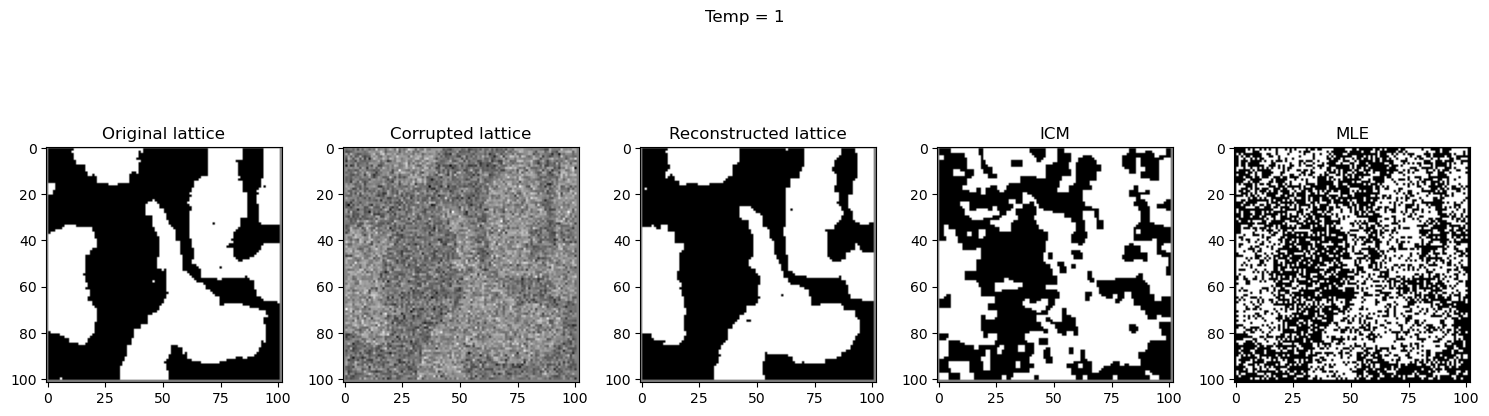

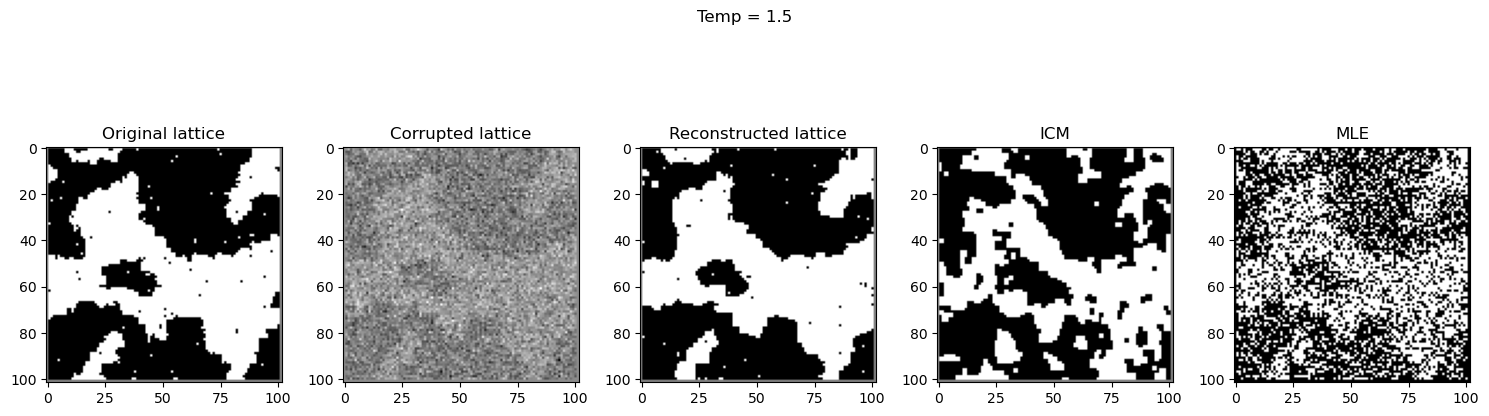

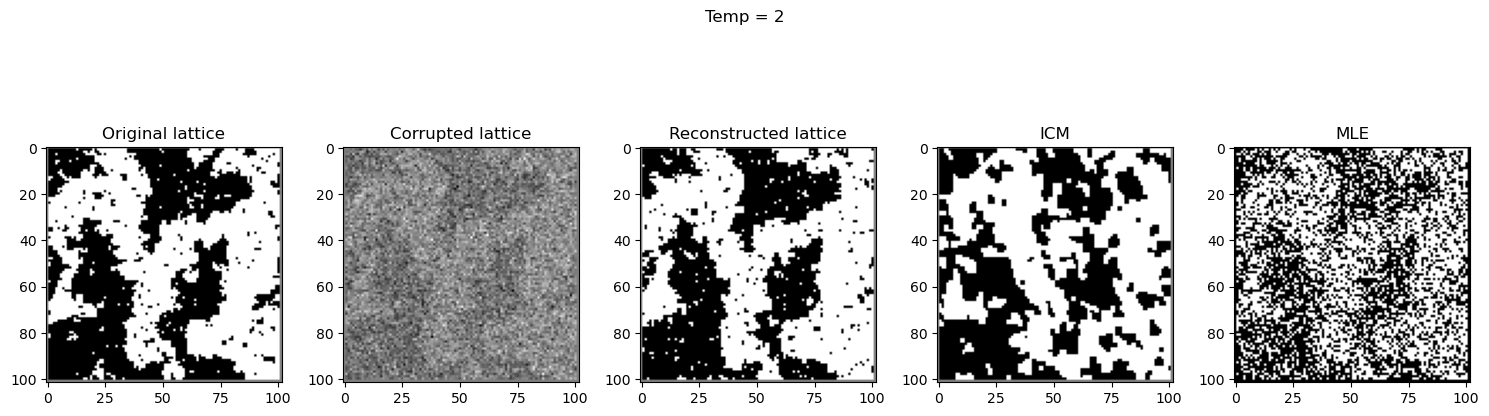

In [10]:
#10.4

temps = [1,1.5,2]
for temp in temps:
      
    lattice = lattice_sampler(temp = temp,size = 100, num_sweeps = 50)     
    noise = noise_sample(size = 100)                                                       
    corrupted_lattice =  lattice + noise
    sampled_ICM = ICM_lattice_sampler(corrupted_lattice,temp,size = 100, num_sweeps = 50)
    sampled_lattice_from_corrupted = corrupted_lattice_sampler(corrupted_lattice,temp,size = 100, num_sweeps = 50)
    MLE = np.where(corrupted_lattice > 0, 1, -1)

    #plot the 5 lattices one next to the other
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    axs[0].imshow(lattice, cmap='gray')
    axs[0].set_title('Original lattice')
    axs[1].imshow(corrupted_lattice, cmap='gray')
    axs[1].set_title('Corrupted lattice')
    axs[2].imshow(sampled_lattice_from_corrupted, cmap='gray')
    axs[2].set_title('Reconstructed lattice')
    axs[3].imshow(sampled_ICM, cmap='gray')
    axs[3].set_title('ICM')
    axs[4].imshow(MLE, cmap='gray')
    axs[4].set_title('MLE')
    fig.suptitle('Temp = ' + str(temp))
    plt.tight_layout()
    plt.show()

    

    

   